In [59]:
import tensorflow as tf
from tensorflow import keras
from random import shuffle
import seaborn as sns
import pandas as pd
import numpy as np
import cv2 as cv
import glob
import os

In [60]:
BATCH_SIZE = 32
NUM_EPOCHS = 10
NUM_CLASSES = 1
t = 150

In [61]:
base_model = keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(t, t, 3))
# Freeze the pretrained weights
for layer in base_model.layers:
    layer.trainable = False

In [62]:
# Added layer to base model
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
predictions = keras.layers.Dense(NUM_CLASSES, activation='sigmoid')(x)

In [63]:
model = keras.models.Model(inputs=base_model.input, outputs=predictions)

optimizer = keras.optimizers.Adam(learning_rate=0.001)
loos_fn = keras.losses.BinaryCrossentropy()
model.compile(optimizer=optimizer, loss=loos_fn, metrics=['accuracy'])

In [64]:
x_train = []
y_train = []
x_test = []
y_test = []

In [65]:
dataTr = []

for filename in glob.glob(os.path.join('C:/Users/navan/OneDrive/Escritorio/database/catdogs/train/cats/','*.jpg')):
    dataTr.append([1, cv.resize(cv.imread(filename), dsize=(t, t), interpolation=cv.INTER_CUBIC)])
for filename in glob.glob(os.path.join('C:/Users/navan/OneDrive/Escritorio/database/catdogs/train/dogs/','*.jpg')):
    dataTr.append([0, cv.resize(cv.imread(filename), dsize=(t, t), interpolation=cv.INTER_CUBIC)])

print('Images loaded', len(dataTr))

Images loaded 4000


In [66]:
# Shuffle data
for i, j in dataTr:
    x_train.append(j)
    y_train.append(i)
x_train = np.array(x_train)/255 # Normalize
y_train = np.array(y_train)

In [67]:
for filename in glob.glob(os.path.join('C:/Users/navan/OneDrive/Escritorio/database/catdogs/test/cats/','*.jpg')):
    x_test.append(cv.resize(cv.imread(filename), dsize=(t, t), interpolation=cv.INTER_CUBIC))
    y_test.append(1)
for filename in glob.glob(os.path.join('C:/Users/navan/OneDrive/Escritorio/database/catdogs/test/dogs/','*.jpg')):
    x_test.append(cv.resize(cv.imread(filename), dsize=(t, t), interpolation=cv.INTER_CUBIC))
    y_test.append(0)

print('Images loaded', len(x_test))
print('Labels loaded', len(y_test))

Images loaded 1000
Labels loaded 1000


In [68]:
x_test = np.array(x_test)/255 # Normalize
y_test = np.array(y_test)

In [69]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',
    min_delta = 0,
    patience = 10,
    verbose = 0,
    restore_best_weights = True
)

In [70]:
nav = model.fit(
    x_train, y_train,
    batch_size = BATCH_SIZE,
    epochs = NUM_EPOCHS,
    callbacks = [early_stopping],
    validation_data = (x_test, y_test)
)

Epoch 1/10
125/125 [==============================] - 55s 408ms/step - loss: 0.3447 - accuracy: 0.9240 - val_loss: 0.1385 - val_accuracy: 0.9560
Epoch 2/10
125/125 [==============================] - 55s 441ms/step - loss: 0.1186 - accuracy: 0.9538 - val_loss: 0.1241 - val_accuracy: 0.9590
Epoch 3/10
125/125 [==============================] - 54s 434ms/step - loss: 0.0810 - accuracy: 0.9675 - val_loss: 0.1100 - val_accuracy: 0.9650
Epoch 4/10
125/125 [==============================] - 53s 425ms/step - loss: 0.0791 - accuracy: 0.9678 - val_loss: 0.1073 - val_accuracy: 0.9670
Epoch 5/10
125/125 [==============================] - 53s 425ms/step - loss: 0.0568 - accuracy: 0.9775 - val_loss: 0.1126 - val_accuracy: 0.9640
Epoch 6/10
125/125 [==============================] - 52s 415ms/step - loss: 0.0348 - accuracy: 0.9872 - val_loss: 0.1191 - val_accuracy: 0.9660
Epoch 7/10
125/125 [==============================] - 51s 406ms/step - loss: 0.0452 - accuracy: 0.9803 - val_loss: 0.1280 - val_ac

In [71]:
history = nav
print(history.history)

{'loss': [0.3447114825248718, 0.11861201375722885, 0.08095622062683105, 0.07912668585777283, 0.056816063821315765, 0.03479497879743576, 0.04523967206478119, 0.02131791226565838, 0.0353272370994091, 0.022098004817962646], 'accuracy': [0.9240000247955322, 0.9537500143051147, 0.9674999713897705, 0.9677500128746033, 0.9775000214576721, 0.9872499704360962, 0.9802500009536743, 0.9925000071525574, 0.9869999885559082, 0.9919999837875366], 'val_loss': [0.13845451176166534, 0.12406717240810394, 0.11003607511520386, 0.10733345150947571, 0.11263705790042877, 0.119122214615345, 0.1279837191104889, 0.23505063354969025, 0.15269151329994202, 0.17148542404174805], 'val_accuracy': [0.9559999704360962, 0.9589999914169312, 0.9649999737739563, 0.9670000076293945, 0.9639999866485596, 0.9660000205039978, 0.9639999866485596, 0.9419999718666077, 0.9660000205039978, 0.9589999914169312]}


In [72]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('Test loss: {0: .4f}. Test accuracy: {1: .2f}%'.format(test_loss, test_acc*100.))

32/32 - 10s - loss: 0.1715 - accuracy: 0.9590 - 10s/epoch - 314ms/step
Test loss:  0.1715. Test accuracy:  95.90%


In [73]:
model.save('catdog1.h5')

Plotting images and the results

In [74]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

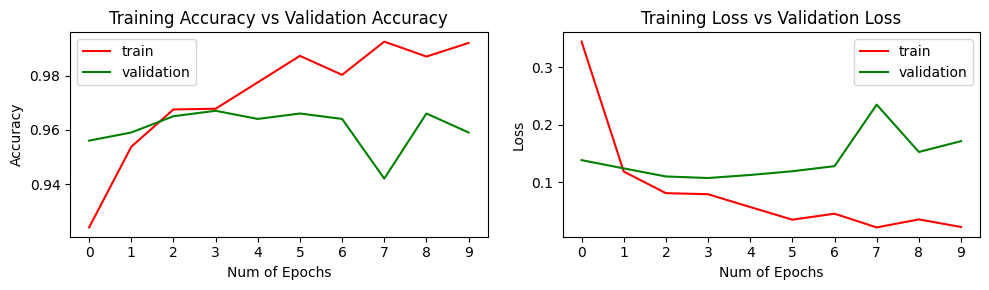

In [75]:
# Datos de entrenamiento
loss = history.history["loss"]
accuracy = history.history["accuracy"]
# Datos de validación
val_loss = history.history["val_loss"]
val_accuracy = history.history["val_accuracy"]

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
# Accuracy
axs[0].plot(accuracy, 'r', label='train')
axs[0].plot(val_accuracy, 'g', label='validation')
axs[0].set_xticks(np.arange(0, 10, 1.0))
axs[0].set_xlabel("Num of Epochs")
axs[0].set_ylabel("Accuracy")
axs[0].set_title("Training Accuracy vs Validation Accuracy")
axs[0].legend()
# Loss
axs[1].plot(loss, 'r', label='train')
axs[1].plot(val_loss, 'g', label='validation')
axs[1].set_xticks(np.arange(0, 10, 1.0))
axs[1].set_xlabel("Num of Epochs")
axs[1].set_ylabel("Loss")
axs[1].set_title("Training Loss vs Validation Loss")
axs[1].legend()
plt.tight_layout()
plt.show()

In [76]:
# predict probabilities for test set
y_pred = model.predict(x_test)
y_pred = np.round(y_pred).astype(int)

32/32 [==============================] - 11s 315ms/step


              precision    recall  f1-score   support

           0       0.97      0.95      0.96       500
           1       0.95      0.97      0.96       500

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



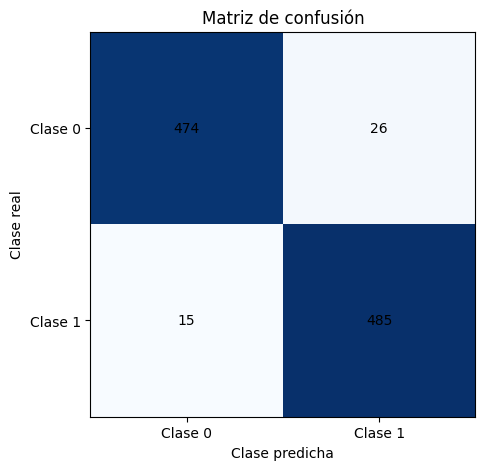

In [77]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Classification report
cr = classification_report(y_test, y_pred)
print(cr)

plt.figure(figsize=(5, 5))
plt.imshow(cm, cmap="Blues")
plt.title("Matriz de confusión")
plt.xlabel("Clase predicha")
plt.ylabel("Clase real")
plt.xticks([0, 1], ["Clase 0", "Clase 1"])
plt.yticks([0, 1], ["Clase 0", "Clase 1"])

for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, cm[i][j], ha='center', va='center')

plt.show()